In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import numpy as np
import cmath
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn

2620
C:\Users\novikau1\Documents\work\codes\QuCF\scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

colors_ = ["blue", "red", "green", "gray", "black"]

cmap_matrix = 'bwr'

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


path_save_ = "./jupyter-notebooks/NL/results/"

for _ in range(30):
    plt.close()

In [3]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# ---------------------------------------------------------------------------------------------------
mix.reload_module(kvn)

# --- two attractors ---
F_ = lambda x:  - x* (x**2 - 0.25)

# t_max, x_max, x_center = 4.0, 1, -0.8
# x_centers_ = [- x_center, x_center, 0.5*x_center, - 0.5*x_center] 

# t_max, x_max, x_center = 4.0, 1, 0.125
# x_centers_ = [- x_center, x_center, 6.*x_center, - 6.*x_center] 

t_max, x_max, x_center = 4.0, 1, 0.25
x_centers_ = [- x_center, x_center, 3.*x_center, - 3.*x_center] 
# ----------------------------------------

flag_sim_ = True # if False, then only plot the resulting matrices;

if flag_sim_:
    nx, nt = 7, 11  # for simulations
else:
    nx, nt = 4, 11  # for plotting


Nx = 1<<nx
Nt = 1<<nt
x = np.linspace(-x_max, x_max, Nx)
t = np.linspace(0,t_max,Nt)
dx = np.diff(x)[0]
dt = np.diff(t)[0]

psi_init_ = np.zeros(Nx, dtype=float)
delta_gauss = 0.05
coef_gauss = 1./(np.sqrt(2.*np.pi) * delta_gauss)
for ii in range(Nx):
    psi_init_[ii] = 0
    for i_center in range(len(x_centers_)):
        psi_init_[ii] += np.exp(-(x[ii] + x_centers_[i_center])**2/(2.*delta_gauss**2)) 
# psi_init_ = np.sqrt(coef_gauss * psi_init_)
psi_init_[0] = 0
psi_init_[Nx-1] = 0
del ii


print("nx: {:d}".format(nx))
print("nt: {:d}".format(nt))
print("sum psi**2: {:0.3e}".format(np.trapz(psi_init_**2, dx=dx)))

sol_ref_several = []


nx: 7
nt: 11
sum psi**2: 3.545e-01


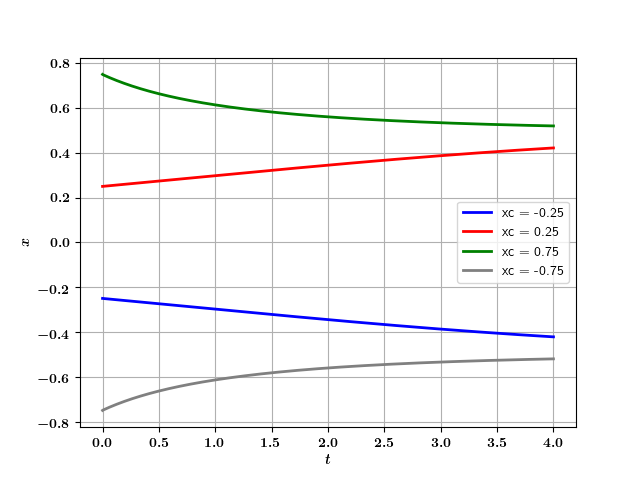

In [5]:
# -----------------------------------------------------------------
# --- Solve d x / d t = - x**2: standart method (for reference) ---
# -----------------------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)

def solve_standart(x_center_ref):
    oo = RK45(
        lambda t,x: F_(x), 
        t[0], 
        [x_center_ref], t[-1], first_step=dt, max_step=dt
    )
    
    sol_ref = np.zeros(Nt, dtype=float)
    sol_ref[0] = x_center_ref
    Nt_act = 1
    
    oo.step()
    oo.t
    while mix.compare_two_strings(oo.status, "running"):
        oo.step()
        Nt_act += 1
        if Nt_act - 1 == Nt:
            print(oo.t)
        sol_ref[Nt_act-1] = float(oo.y[0])
    return sol_ref
# --------------------------------------------------------------------------

if flag_sim_:
    sol_refs = []
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i_center in range(len(x_centers_)):
        x_center = x_centers_[i_center]
    
        # --- Solve for the particular x_center ---
        sol_one = solve_standart(x_center)
        sol_refs.append(sol_one)
    
        # --- Plotting ---
        ax.plot(
            t, sol_one, 
            color=colors_[i_center], linewidth = 2, linestyle='-', 
            label = "xc = {:0.2f}".format(x_center)
        )
        del x_center
    plt.xlabel('$t$')
    plt.ylabel("$x$")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Simulations are blocked.")

In [6]:
# -----------------------------------------------------------------------------------------------------
# --- FUNCTIONS for the construction and analysis of KvN matrix ---
# * an eigenvalue is degenerate if there are several eigenvectors that correspond to this eigenvalue
# -----------------------------------------------------------------------------------------------------
from scipy.linalg import eig
mix.reload_module(mix)

# ---------------------------------------------------------------------------
def is_Hermitian(A, name):
    inds_nonzero = np.nonzero(np.transpose(np.conjugate(A)) - A)
    if np.size(inds_nonzero) == 0:
        print("the matrix {:s} is Hermitian".format(name))
    else:
        print("the matrix {:s} is non-Hermitian".format(name))
    return

# ---------------------------------------------------------------------------
def construct_CD_matrix():
    H_CD = np.zeros((Nx, Nx), dtype=complex)
    for ii in range(1,Nx-1):
        Fm = F_(x[ii-1]) 
        Fc = F_(x[ii]) 
        Fp = F_(x[ii+1]) 
        H_CD[ii,ii-1] = - (Fm + Fc)
        H_CD[ii,ii+1] =   (Fp + Fc)
    H_CD = -1j/(4.*dx) * H_CD
    H_CD[1,0] = 0.0
    H_CD[Nx-2, Nx-1] = 0.0
    return H_CD

# ---------------------------------------------------------------------------
def construct_UW_matrix():
    H_UW = np.zeros((Nx, Nx), dtype=complex)

    # --- left ---
    Fc = F_(x[0])
    if Fc <= 0:
        Fp = F_(x[ii+1])
        H_UW[0,0] = - 2 * Fc
        H_UW[0,1] = Fp + Fc
    else:
        H_UW[0,0]   = 2 * Fc
    # --- bulk ---    
    for ii in range(1,Nx-1):
        Fc = F_(x[ii])

        if Fc <= 0:
            Fp = F_(x[ii+1])
            H_UW[ii,ii]   = - 2 * Fc
            H_UW[ii,ii+1] = Fp + Fc
        else:
            Fm = F_(x[ii-1])
            H_UW[ii,ii]   = 2 * Fc
            H_UW[ii,ii-1] = - (Fm + Fc)
    # --- right ---
    Fc = F_(x[Nx-1])
    if Fc <= 0:
        H_UW[Nx-1,Nx-1]   = - 2 * Fc
    else:
        Fm = F_(x[Nx-2])
        H_UW[Nx-1,Nx-1]   = 2 * Fc
        H_UW[Nx-1,Nx-2] = - (Fm + Fc)
    # ---
    H_UW = -1j/(2.*dx) * H_UW
    # H_UW[Nx-2, Nx-1] = 0.0
    return H_UW

In [7]:
# -----------------------------------------------------------------------------------------------------
# --- CONSTRUCT the KvN matrix ---
# -----------------------------------------------------------------------------------------------------
mix.reload_module(mix)

print("--- CENTRAL DIFFERENCE SCHEME ---")
H_CD     = construct_CD_matrix()
is_Hermitian(H_CD, "CD")

print("--- UPWINDING DIFFERENCE SCHEME ---")
H_UW     = construct_UW_matrix()
is_Hermitian(H_UW, "UW")

--- CENTRAL DIFFERENCE SCHEME ---
the matrix CD is Hermitian
--- UPWINDING DIFFERENCE SCHEME ---
the matrix UW is non-Hermitian


In [8]:
# --------------------------------------------------------------------------------
# --- Solve the system by using the matrix ---
# --------------------------------------------------------------------------------
from numba import njit
import time

# -------------------------------------------------
def solve_using_matrix(A):
    psi_tx = np.zeros((Nt,Nx), dtype = complex)
    psi_tx[0,:] = np.array(psi_init_)

    coef_dt = dt * (-1j)
    for it in range(Nt-1):
        Hpsi = A.dot(psi_tx[it])

        for ix in range(1, Nx-1):
            psi_tx[it+1, ix] = psi_tx[it, ix] + coef_dt * Hpsi[ix]
    return psi_tx


def compute_mean(psi_tx_matrix):
    # x_operator = np.diag(x)
    mean_t = np.zeros(Nt)
    for it in range(Nt):
        psi_t1   = psi_tx_matrix[it,:]
        psi_t1_c = np.conjugate(psi_t1)
        norm = psi_t1_c.dot(psi_t1) * dx
        mean_t[it] = np.real(np.trapz(x*psi_t1_c*psi_t1, dx=dx) / norm)
    return mean_t
# -------------------------------------------------

if flag_sim_:
    st = time.time()
    
    psi_tx_matrix_CD   = solve_using_matrix(H_CD)
    psi_tx_matrix_UW   = solve_using_matrix(H_UW)
    
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    # --- Compute the mean value ---
    mean_t_CD   = compute_mean(psi_tx_matrix_CD)
    mean_t_UW   = compute_mean(psi_tx_matrix_UW)
else:
    print("Simulations are blocked.")

Execution time: 0.3442676067352295 seconds


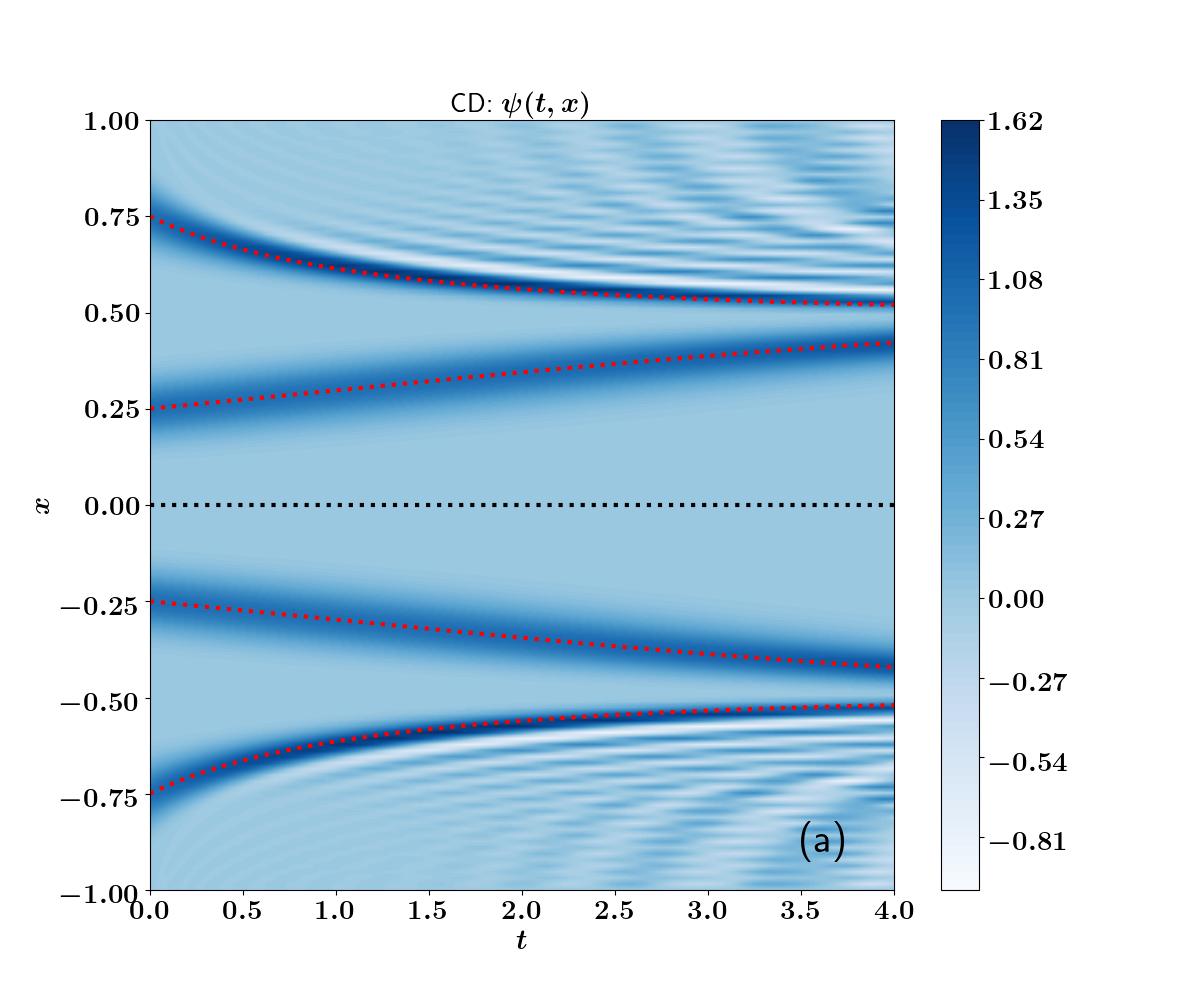

In [9]:
# ---------------------------------------------------------------------------------------------------
# --- Plot psi_tx_matrix(t,x) ---
# ---------------------------------------------------------------------------------------------------

if flag_sim_:
    psi_tx_plot, mean_t_plot, str_title, str_fig = psi_tx_matrix_CD, mean_t_CD, "CD: ", "(a)"
    # psi_tx_plot, mean_t_plot, str_title, str_fig = psi_tx_matrix_UW, mean_t_UW, "UW: ", "(b)"
    
    fontsize = 20
    
    # --- Plotting ---
    XX, YY = np.meshgrid(t, x)
    fig_tx = plt.figure(figsize=(12, 10))
    ax = fig_tx.add_subplot(111)
    cs = ax.contourf(XX, YY, np.transpose(psi_tx_plot.real), levels=100, cmap=cmap_two_signs_)
    
    # cb = fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    cb = fig_tx.colorbar(cs, ax = ax)
    cb.ax.ticklabel_format(style="scientific")
    cb.ax.tick_params(labelsize=fontsize) 
    
    ax.plot(t, mean_t_plot, color='black', linewidth = 3.0, linestyle=':', label="mean")
    
    ax.plot(t, sol_refs[0], color='r', linewidth = 3.0, linestyle=':', label="ref")
    for i_ref in range(1,len(sol_refs)):
        ax.plot(t, sol_refs[i_ref], color='r', linewidth = 3.0, linestyle=':')
    
    # ax.legend()
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_ylabel('$x$', fontsize = fontsize)
    ax.set_title(str_title + '$\psi(t,x)$', fontsize = fontsize)
    ax.set_xlim(0, t_max)
    ax.set_ylim(-x_max, x_max)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.text(3.5, -0.9, str_fig, fontsize=1.5*fontsize)
    
    del fontsize, fig_tx
else:
    print("Simulations are blocked.")

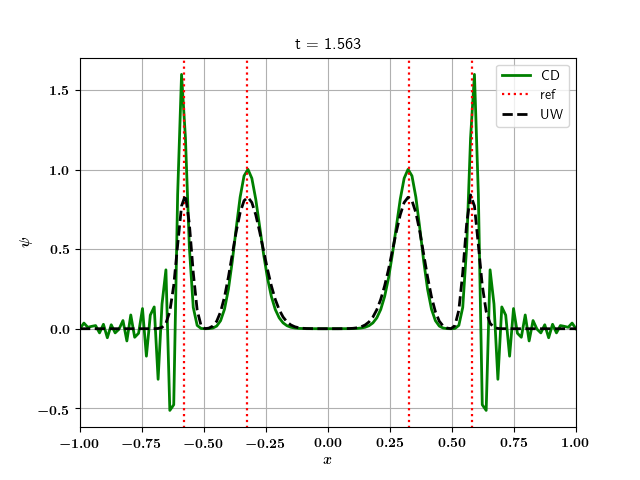

write data to a file: ./jupyter-notebooks/NL/results//CD_x_t1.dat
write data to a file: ./jupyter-notebooks/NL/results//UW_x_t1.dat

--- reference points ---
-3.247e-01
3.247e-01
5.789e-01
-5.789e-01

chosen time moment: 1.563


In [16]:
# ---------------------------------------------------------------------------------------------------
# --- Plot psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------

flag_save_ = False
fname_CD = "CD_x_t1.dat"
fname_UW = "UW_x_t1.dat"
idt_moment = 160*5

# ------------------------------------------------------------
if flag_sim_:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        x, psi_tx_matrix_CD.real[idt_moment,:], 
        color="green", linewidth = 2.0, linestyle='-',
        label = "CD"
    )
    ax.axvline(
        sol_refs[0][idt_moment], 
        ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
        color = "r", linewidth = 1.6, linestyle = ":",
        label = "ref"
    )
    for i_center in range(1, len(sol_refs)):
        ax.axvline(
            sol_refs[i_center][idt_moment], 
            ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
            color = "r", linewidth = 1.6, linestyle = ":"
        )
    ax.plot(
        x, psi_tx_matrix_UW.real[idt_moment,:], 
        color="black", linewidth = 2.0, linestyle='--',
        label = "UW"
    )
    plt.xlim([-x_max,x_max])
    plt.xlabel('$x$')
    plt.ylabel("$\psi$")
    plt.title("t = {:0.3f}".format(t[idt_moment]))
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Save the 1D data ---
    if flag_save_:
        mix.save_dat_plot_1d_file(
            path_save_ + "/" + fname_CD, 
            x, 
            psi_tx_matrix_CD.real[idt_moment,:]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/" + fname_UW, 
            x, 
            psi_tx_matrix_UW.real[idt_moment,:]
        )
    # --- Print the reference points ---
    print("\n--- reference points ---")
    for i_center in range(len(sol_refs)):
        print("{:0.3e}".format(sol_refs[i_center][idt_moment]))
    print()
    print("chosen time moment: {:0.3f}".format(t[idt_moment]))
else:
    print("Simulations are blocked.")

del idt_moment

In [17]:
# ----------------------------------------------------------
# --- Find the Hermitian and anti-Hermitian parts of i*H ---
# ----------------------------------------------------------
mix.reload_module(kvn)
Ah_, Aa_ = kvn.get_herm_aherm_parts(1j * H_UW)

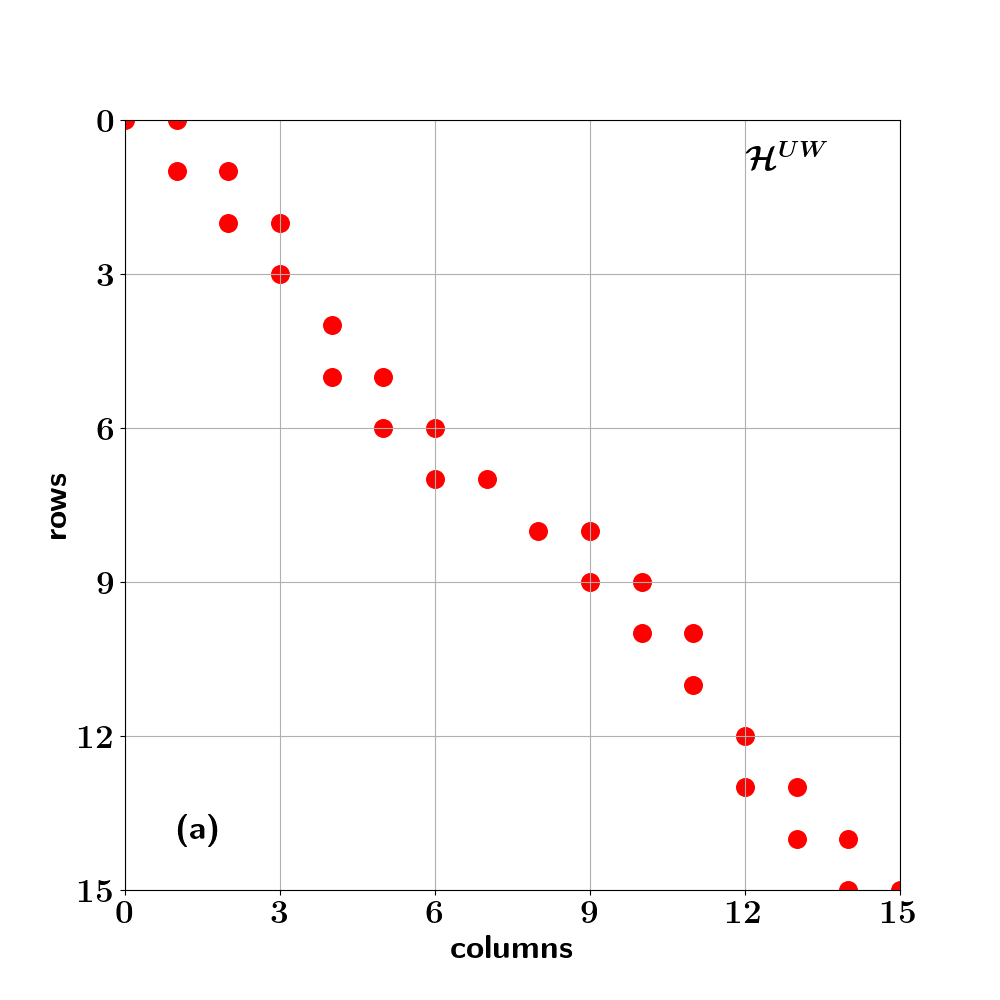

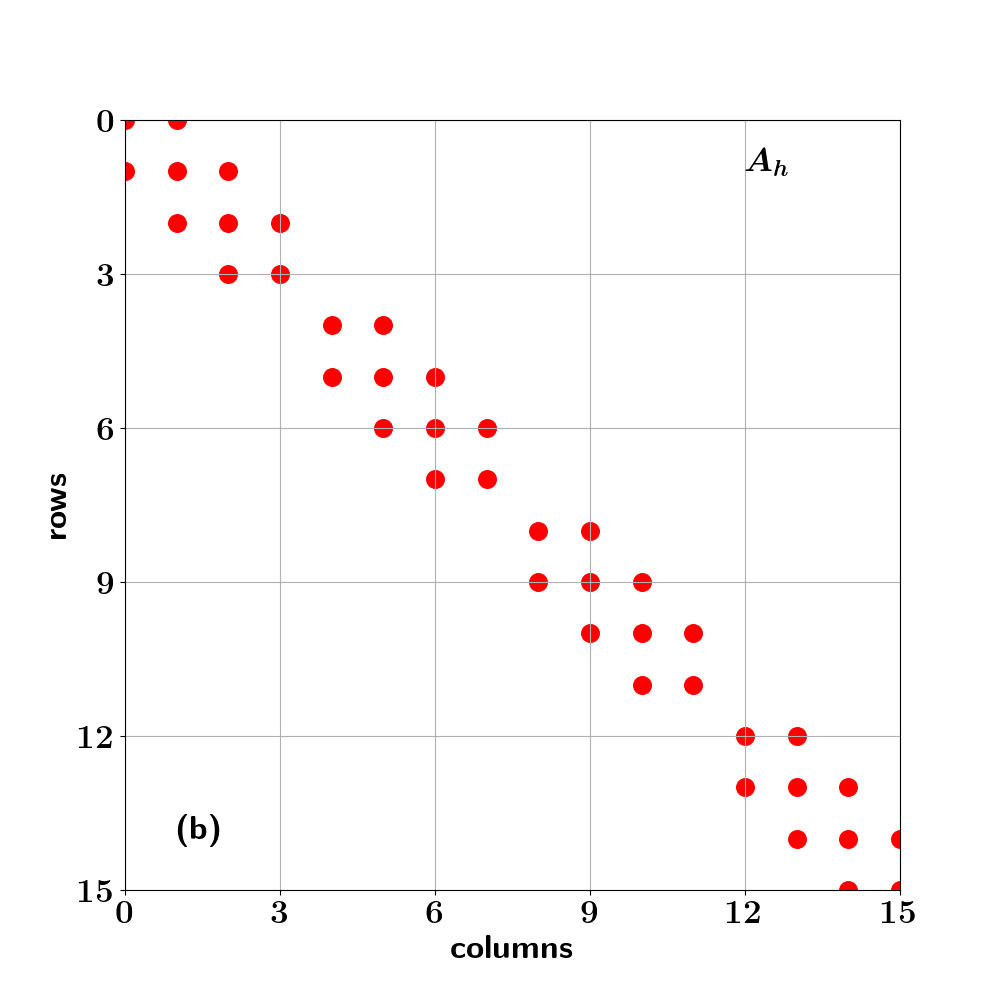

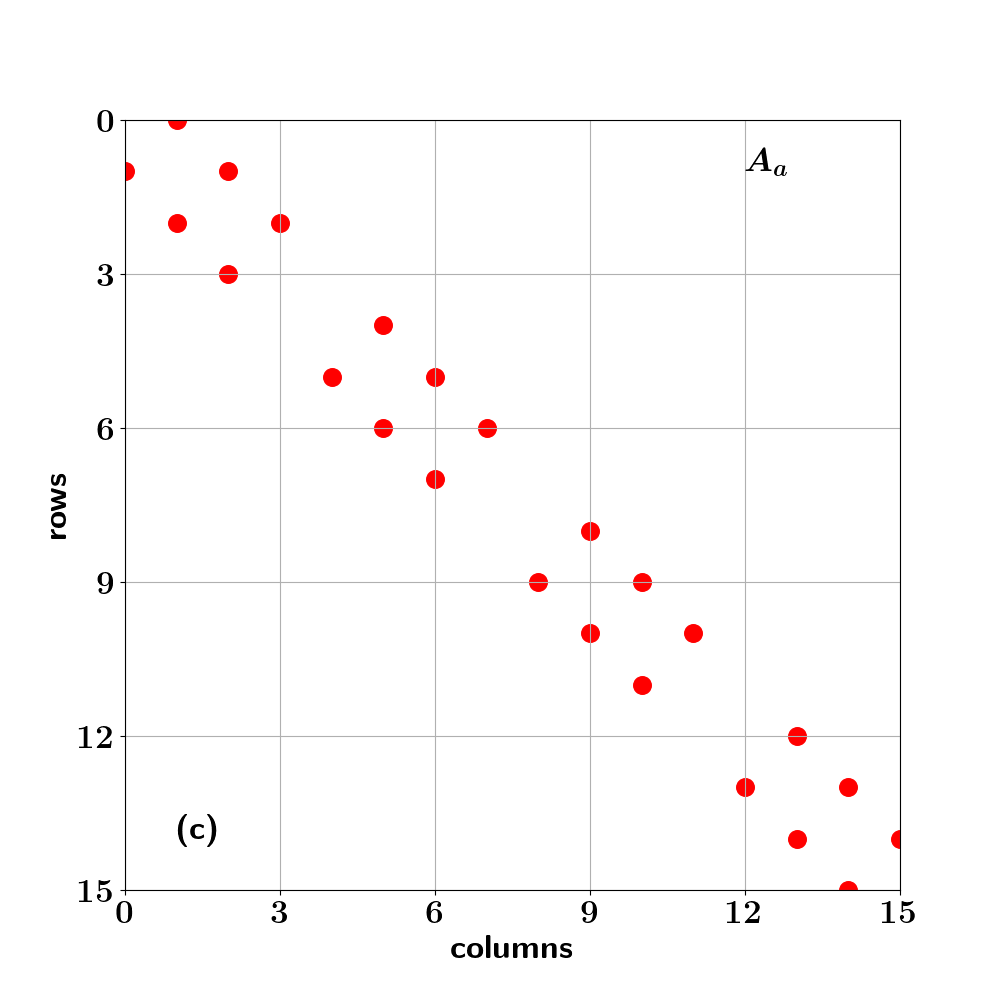

In [23]:
# ---------------------------------------
# --- Plot matrices ---
# ---------------------------------------
mix.reload_module(kvn)

if not flag_sim_:
    flag_save = False
    path_save = "./jupyter-notebooks/NL/results"

    
    # matrix_labels = ["", "", ""]
    matrix_labels = ["(a)", "(b)", "(c)"]
    
    kvn.plot_A_structure(
        H_UW, "\mathcal{H}^{UW}",
        matrix_labels[0], "fig_x2_H",
        flag_save = flag_save, 
        path_save = path_save
    )
    kvn.plot_A_structure(
        Ah_, "A_h",
        matrix_labels[1], "fig_x2_Ah",
        flag_save = flag_save, 
        path_save = path_save
    )
    kvn.plot_A_structure(
        Aa_, "A_a",
        matrix_labels[2], "fig_x2_Aa",
        flag_save = flag_save, 
        path_save = path_save
    )
else:
    print("Plotting of matrices is blocked.")

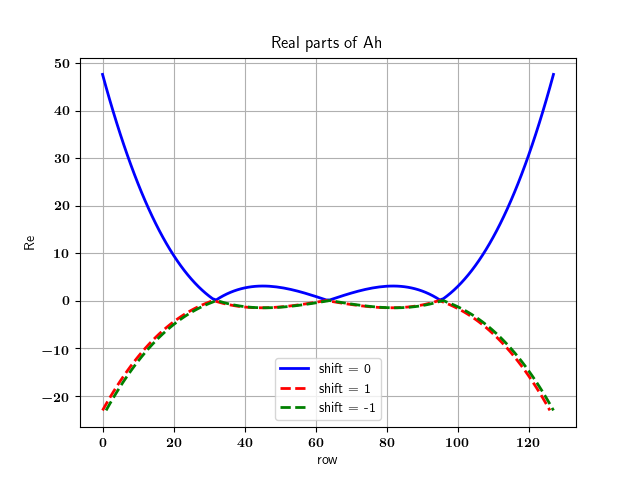

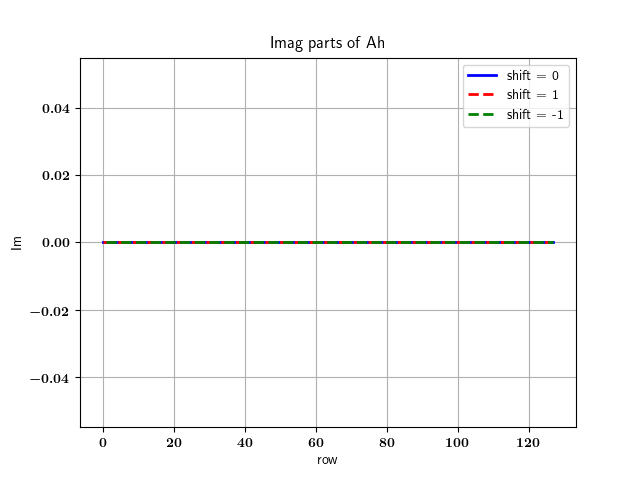

In [20]:
# ---------------------------------------------------------
# --- Print diagonals from matrices ---
# ---------------------------------------------------------
def get_diag(A, i_shift):
    N = A.shape[0]
    diag = np.zeros(N-np.abs(i_shift), dtype=A.dtype)
    if i_shift >= 0:
        chosen_range = range(N-i_shift)
        for ir in range(N-i_shift):
            diag[ir] = A[ir, ir + i_shift]
    else:
        chosen_range = range(-i_shift, N)
        for ir in chosen_range:
            diag[ir + i_shift] = A[ir, ir + i_shift]
    row_range = np.array(chosen_range)
    return diag, row_range


# ---------------------------------------------------------
A_plot, A_name = Ah_, "Ah"
# A_plot, A_name = Aa_, "Aa"

sh_1 = 0
diag_1, rows_1 = get_diag(A_plot, i_shift = sh_1)

sh_2 = 1
diag_2, rows_2 = get_diag(A_plot, i_shift = sh_2)

sh_3 = -1
diag_3, rows_3 = get_diag(A_plot, i_shift = sh_3)


# --- Real parts ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rows_1, diag_1.real, color='b', linewidth = 2, linestyle='-', label = "shift = {:d}".format(sh_1))
ax.plot(rows_2, diag_2.real, color='r', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_2))
ax.plot(rows_3, diag_3.real, color='g', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_3))
plt.xlabel('row')
plt.ylabel("Re")
plt.title("Real parts of {:s}".format(A_name))
plt.legend()
plt.grid(True)
plt.show()

# --- Imaginery parts ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rows_1, diag_1.imag, color='b', linewidth = 2, linestyle='-', label = "shift = {:d}".format(sh_1))
ax.plot(rows_2, diag_2.imag, color='r', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_2))
ax.plot(rows_3, diag_3.imag, color='g', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_3))
plt.xlabel('row')
plt.ylabel("Im")
plt.title("Imag parts of {:s}".format(A_name))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# --- Compute the coefficients fot the QSVT computations of the diagonals ---
# -----------------------------------------------------------------------------

# Should i instead create a class for the computation of the QSVT coefficients and use it ?

# --- Normalize the matrices ---